We will now use python to do some wavelet analysis. As usual, we have to import a few packages.

In [61]:
import h5py
import spectrum
import analytic_wavelet
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

from scipy import signal, ndimage, fft


sns.set()
sns.set_style("whitegrid")

<IPython.core.display.Javascript object>


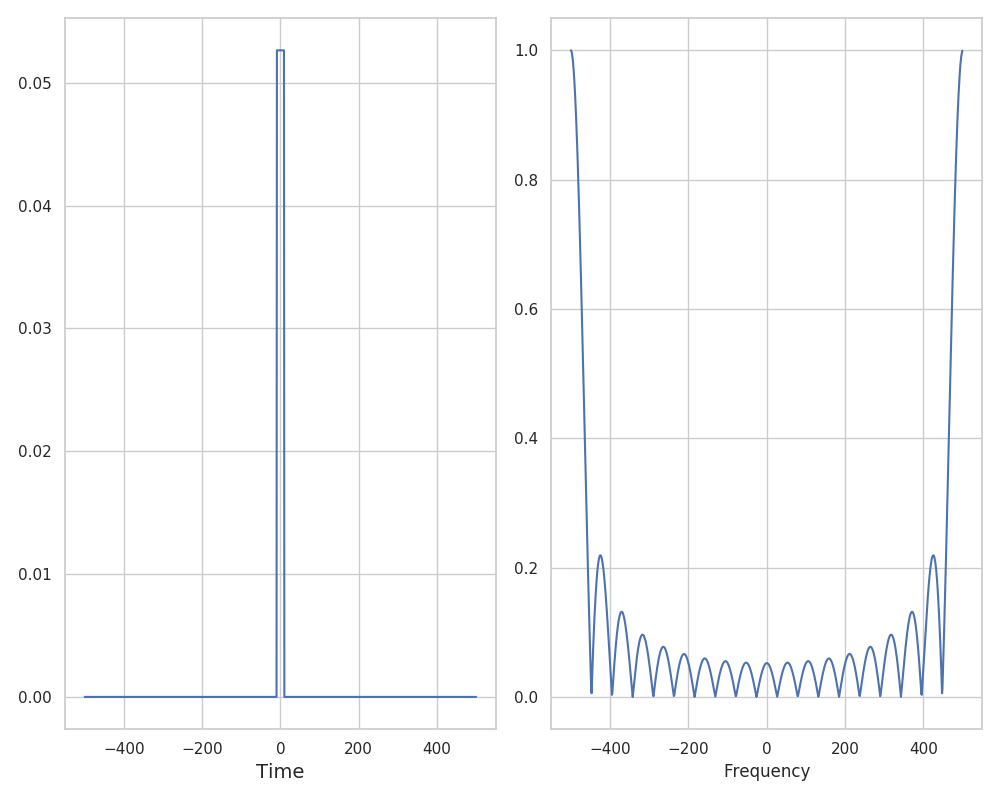

In [62]:
t = np.arange(1, 1002)
t = t - np.mean(t)
g = np.zeros(len(t))
g[np.abs(t) < 10] = 1/19

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(t, g)
ax[0].set_xlabel("Time", fontsize=14)

ax[1].plot(t, np.abs(fft(g)))
ax[1].set_xlabel("Frequency")

fig.tight_layout()

Hello

<IPython.core.display.Javascript object>


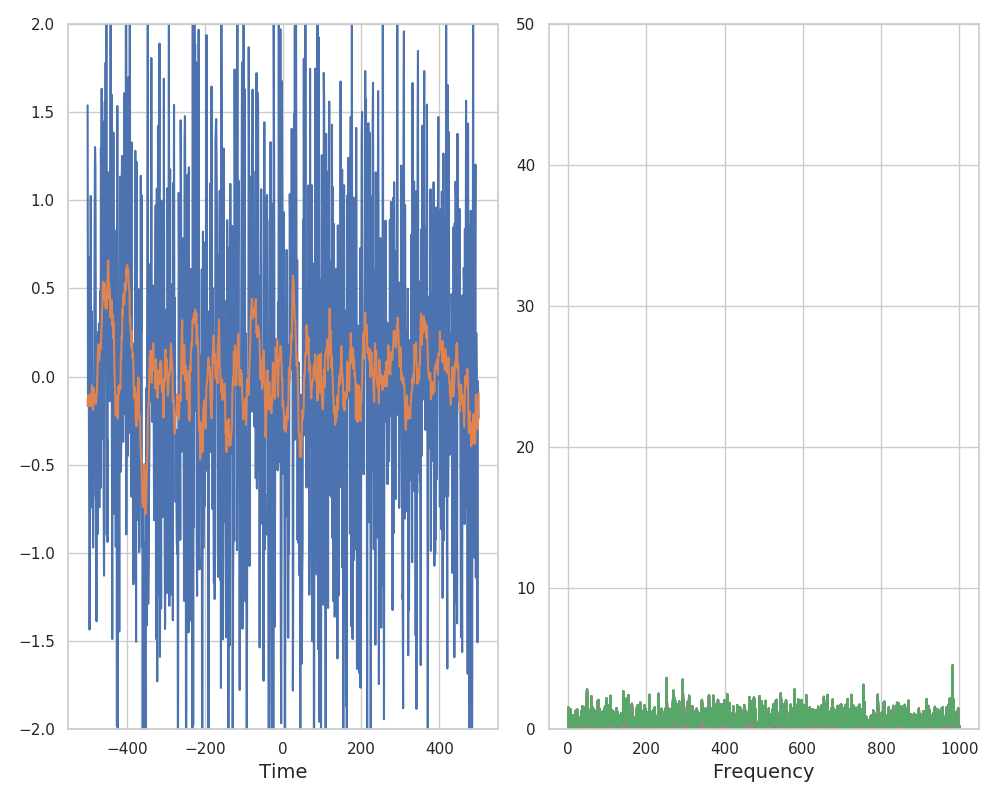

In [63]:
x = np.random.randn(1001,1)
fx = ndimage.convolve1d(x, np.ones(19)/19, mode="mirror", axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(t, x)
ax[0].plot(t, fx)
ax[0].set_xlabel("Time", fontsize=14)
ax[0].set_ylim(-2, 2)

ax[1].plot(np.abs(sp.fft(x)))
ax[1].plot(np.abs(sp.fft(fx)))
ax[1].plot(np.abs(sp.fft(x)*sp.fft(g)))
ax[1].set_xlabel("Frequency", fontsize=14)
ax[1].set_ylim(0, 50)

fig.tight_layout()

Hello

In [33]:
datadir = "../data/"
filename = "m1244.mat"
with h5py.File(datadir + filename,'r') as file:
    # Looking at contents of file
    print(file.keys())
    # Finding the variables contained in the key
    variables = list(file.get("{}".format(filename[:filename.find(".")])))
    print(variables)

    # Storing the variables in a dictionary
    data = {}
    for i in variables:
        data[i] = np.array(file.get("{0}/{1}".format(filename[:filename.find(".")], i))).squeeze()  # removes excessive dims

    # Convert a complex tuple (real, imag) to a complex number a + jb
    cv = np.zeros((data["cv"].shape[0], data["cv"].shape[1]), dtype=complex)
    for i in range(len(data["cv"])):
        for j in range(len(data["cv"][0])):
            cv[i][j] = data["cv"][i][j][0] + 1j*data["cv"][i][j][1]
    data["cv"] = cv

    # Convert matlab datenum format to a datetime object for aesthetics
    num = []
    for i in data["num"]:
        num.append(dt.datetime.fromordinal(int(i)) + dt.timedelta(days=i%1) - dt.timedelta(days = 366))
    data["num"] = np.array(num)

<KeysViewHDF5 ['#refs#', 'm1244']>
['creator', 'cv', 'depths', 'description', 'lat', 'link', 'lon', 'num', 'p', 't', 'timestamp']


Hello

<IPython.core.display.Javascript object>


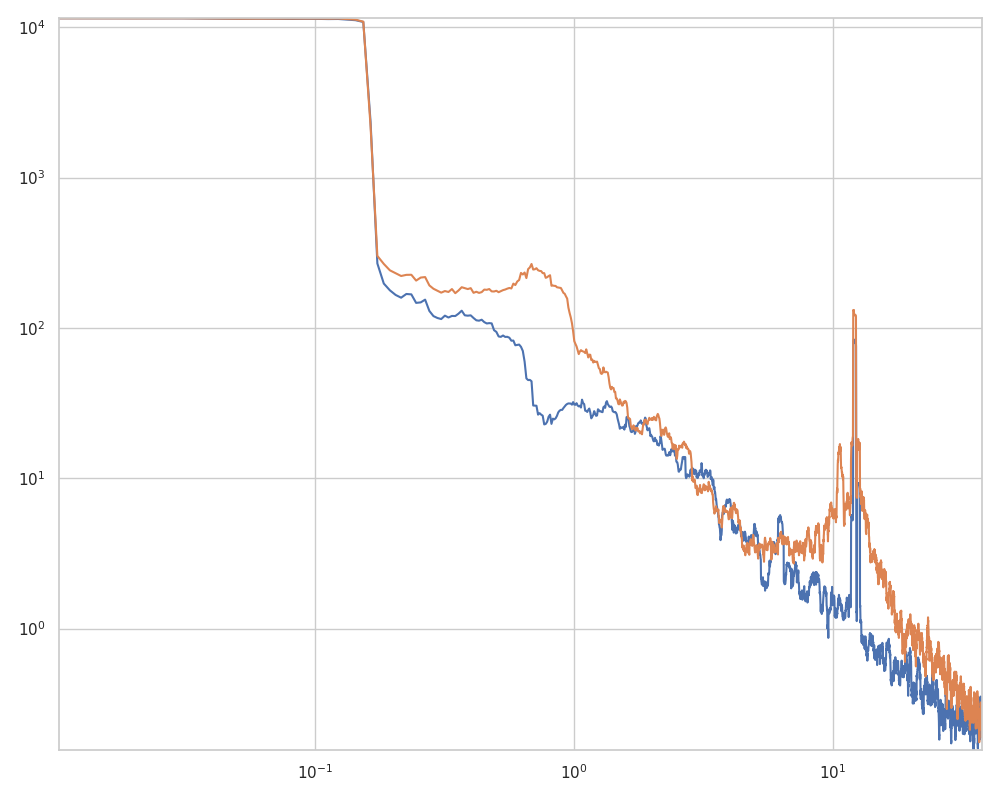

In [64]:
delta = data["num"][1] - data["num"][0]
delta = delta.seconds/60/60/24  # sample rate in days
cv3 = data["cv"][3]
cv3_centered = cv3 - np.mean(cv_3)

f, p = signal.periodogram(cv3_centered, fs=1/delta*2*np.pi)

NW = 16
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv3_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv3_centered))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
p = np.mean(Sk*eigenvalues, axis=1) * delta

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.loglog(f[f >= 0], p[np.where(f >= 0)])
ax.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
ax.autoscale(enable=True, tight=True)
fig.tight_layout()

 

Now for wavelet smoothing

In [77]:
omega=2*np.pi*1200/len(cv3_centered);
wavelet = analytic_wavelet.GeneralizedMorseWavelet(3, 10).make_wavelet(len(cv3_centered), omega)
print(wavelet)
cvo = 1/np.sqrt(2)*np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv3_centered), wavelet, False))
cvr = cv - cvo

"""cvo=frac(1,sqrt(2))*conj(wavetrans(conj(cv),{3,100,omega})); 
cvr=cv-cvo;%Residual minus filtered version 
[f,sppo,snno]=mspec(dt,cvo,psio);%Spectrum of filtered version
[f,sppr,snnr]=mspec(dt,cvr,psio);%Spectrum of residual
clf
%The next line returns the filter used by wavetrans
[psi,psif]=morsewave(length(cv),3,100,omega,'bandpass');
subplot(1,2,1),plot(f,[snn snnr])
axis(ax),xlog,ylog,xlim([max(f)/10 max(f)]),linestyle U T,flipx
hold on,plot(f,50*squared(psif(1:length(f))),'k') %get positive side only
subplot(1,2,2),plot(f,[spp sppr])
axis(ax),xlog,ylog,xlim([max(f)/10 max(f)]),linestyle U T
packfig(1,2,'columns') %pack the column subplots together"""

(array([[ 1.38182927e-16-1.56024797e-16j,  2.05977173e-16+1.13304202e-16j,
        -4.21115832e-17+2.68239884e-16j, ...,
         3.53802231e-17+2.65674688e-16j, -2.06718503e-16+1.06466891e-16j,
        -1.32453811e-16-1.60032521e-16j]]), array([[0.00000000e+00, 9.05452782e-30, 9.27183636e-27, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]))


"cvo=frac(1,sqrt(2))*conj(wavetrans(conj(cv),{3,100,omega})); \ncvr=cv-cvo;%Residual minus filtered version \n[f,sppo,snno]=mspec(dt,cvo,psio);%Spectrum of filtered version\n[f,sppr,snnr]=mspec(dt,cvr,psio);%Spectrum of residual\nclf\n%The next line returns the filter used by wavetrans\n[psi,psif]=morsewave(length(cv),3,100,omega,'bandpass');\nsubplot(1,2,1),plot(f,[snn snnr])\naxis(ax),xlog,ylog,xlim([max(f)/10 max(f)]),linestyle U T,flipx\nhold on,plot(f,50*squared(psif(1:length(f))),'k') %get positive side only\nsubplot(1,2,2),plot(f,[spp sppr])\naxis(ax),xlog,ylog,xlim([max(f)/10 max(f)]),linestyle U T\npackfig(1,2,'columns') %pack the column subplots together"